<a href="https://colab.research.google.com/github/kkkkk2017/variable_impact_user_study/blob/main/variables_impacts_in_user_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.dummy import DummyClassifier
from sklearn.base import clone
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from google.colab import files
from scipy.stats import t

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#split the dataset into training set and testing set. (Leave-One-Participant-Out)
def split(df, features, ylabel='TASK', p=None):
  """parameters:
        df: input data frame
        features: feature labels
        ylabel: the class label, default='TASK'
        p: the participant to leave out. The dafult value is None, this function will randomly select one participant. 
    """
  user = df.PID.unique() #participant ids list

  #get one participant id to leave out. 
  if p is None:
    lop = random.randint(0, len(user)-1)
    lop = user[lop]
  else:
    lop = user[p]
  
  #get the training set. 
  train = df[df.PID != lop]

  train = shuffle(train)

  #get the testing set,
  test = df[df.PID == lop]
  test = shuffle(test)

  train_x = train[features]
  train_y = train[ylabel]

  test_x, test_y = test[features], test[ylabel]

  train_y = LabelEncoder().fit_transform(train_y)
  test_y = LabelEncoder().fit_transform(test_y)

  return train_x, train_y, test_x, test_y

#plot confusion matrix
def display_cm(cm, labels, title):
    _, ax= plt.subplots(1, figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues, square=True, 
                xticklabels=labels, 
                yticklabels=labels, linewidths=0.2, cbar=False,
                annot_kws={
                'fontsize': 13,
            })
    ax.set_xlabel('Predicted labels', fontsize=13)
    ax.set_ylabel('True labels', fontsize=13)
    ax.set_title('Confusion Matrix - '+title, fontsize=13)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)


def train(model, df, features, ylabel='TASK', varf=None):
  """
  Train the input model for all 7 participants, and return the aggregated confusion matrix and scores.
  Parameters:
    model: the input ML model
    df: the input dataset
    features: feature labels (signal features)
    ylabel: class label, default is TASK
    varf: the extra variable feature label. If none, the function will train only with the signal features. Otherwise, it will add the variable label in to the feature set. 
  """
  aucs = [] #AUC score
  f1 = [] #f1 score
  acc = [] #accuracy score

  ys_true = np.array([])
  ys_pred = np.array([])

  df[features] = StandardScaler().fit_transform(df[features])

  if varf is not None:
    features = np.concatenate([features, [varf]])

  for i in range(7):
    X_train, y_train, X_test, y_test = split(df, features, ylabel=ylabel, p=i)

    clf = clone(model)
    clf = clf.fit(X_train, y_train)

    #get the evaluation score
    # y_result = clf.predict(X_train)
    # eval_scores.append(f1_score(y_pred=y_result, y_true=y_train, average='macro'))

    y_pred = clf.predict(X_test)
    ys_true = np.concatenate([ys_true, y_test])
    ys_pred = np.concatenate([ys_pred, y_pred])
    # print(i, np.unique(y_test, return_counts=True), np.unique(y_pred, return_counts=True))

    f1.append(f1_score(y_pred=y_pred, y_true=y_test, average='macro'))
    acc.append(accuracy_score(y_pred=y_pred, y_true=y_test))

    try:
      aucs.append(roc_auc_score(y_test, clf.decision_function(X_test)))
    except:
      continue

  cm = confusion_matrix(ys_true, ys_pred)
  print(f'F1: {np.mean(f1): .3f}, ACC: {np.mean(acc): .3f}, AUC: {np.mean(aucs):.3f}')

  return aucs, f1, acc, cm

#compute 95% confident interval
def ci(x):
  x = np.array(x)
  m = x.mean() 
  s = x.std() 
  dof = len(x)-1 
  confidence = 0.95
  t_crit = np.abs(t.ppf((1-confidence)/2, dof))
  ci = s*t_crit/np.sqrt(len(x))
  return ci

## import data

In [ ]:
df = pd.read_csv(data_file, index_col=0)
df = df[ (df.TASK != 'Base1') & (df.TASK != 'Base2')] #remove baseline activity
df.head(3), df.shape

(   EDA_mean  EDA_d1_mean  EDA_d2_mean     TASK  PID  BVP_mean  BVP_d1_mean  \
 1  0.018516     0.000078     0.000039    Read1  PA1  0.536891     0.000022   
 2  0.054409     0.000075     0.000038  Listen1  PA1  0.536889     0.000054   
 3  0.136268     0.000208     0.000104   Write1  PA1  0.536887     0.000844   
 
    BVP_d2_mean   PD_mean  PD_median  PD_std_mean  duration  engage_score  \
 1     0.000011  2.503463   2.491656     0.095782     197.8           1.8   
 2     0.000027  2.580568   2.566510     0.109277     229.0           3.6   
 3     0.000422  2.963827   2.954022     0.116616     209.7           5.0   
 
    section if_engage  TURN  time_spent  
 1        1        No     2       337.9  
 2        1       Yes     3       566.9  
 3        1       Yes     4       776.6  ,
 (56, 17))

In [ ]:
features = np.array(['EDA_mean', 'EDA_d1_mean', 'EDA_d2_mean', 'BVP_mean', 'BVP_d1_mean', 'BVP_d2_mean', 'PD_mean', 'PD_median', 'PD_std_mean'])
users = df.PID.unique()
df.TASK = [t[:-1].upper() for t in df.TASK]
labels = df.TASK.unique()
labels, features, features.shape

(array(['READ', 'LISTEN', 'WRITE', 'SPEAK'], dtype=object),
 array(['EDA_mean', 'EDA_d1_mean', 'EDA_d2_mean', 'BVP_mean',
        'BVP_d1_mean', 'BVP_d2_mean', 'PD_mean', 'PD_median',
        'PD_std_mean'], dtype='<U11'),
 (9,))

## EXP1: compare models

In [ ]:
accuracys = []

F1:  0.190, ACC:  0.214, AUC: nan


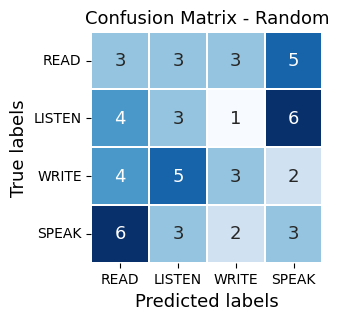

In [ ]:
_, _, acc, cm = train(DummyClassifier(strategy='uniform'), df, features)
accuracys.append(('Random', acc))
display_cm(cm, labels, 'Random')

F1:  0.370, ACC:  0.446, AUC: nan


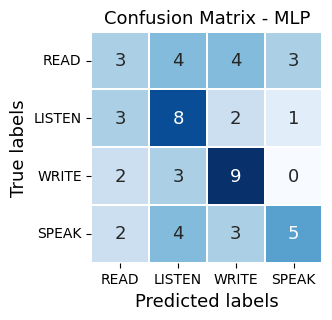

In [ ]:
_, _, acc, cm = train(MLPClassifier(activation='relu', solver='adam'), df, features) 
accuracys.append(('MLP', acc))
display_cm(cm, labels, 'MLP')

F1:  0.381, ACC:  0.446, AUC: nan


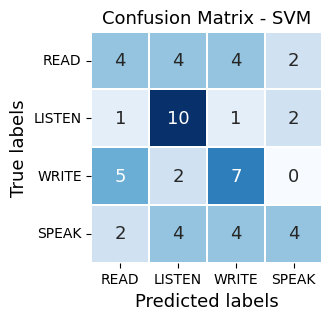

In [ ]:
_, _, acc, cm = train(SVC(kernel='rbf'), df, features)
accuracys.append(('SVM', acc))
display_cm(cm, labels, 'SVM')

F1:  0.322, ACC:  0.393, AUC: nan


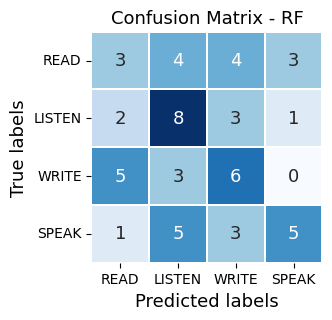

In [ ]:
_, _, acc, cm = train(RandomForestClassifier(max_depth=4), df, features)
accuracys.append(('RF', acc))
display_cm(cm, labels, 'RF')

F1:  0.393, ACC:  0.446, AUC: nan


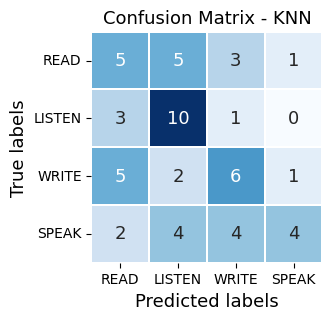

In [ ]:
_, _, acc, cm = train(KNeighborsClassifier(weights='distance'), df, features)
accuracys.append(('KNN', acc))
display_cm(cm, labels, 'KNN')

F1:  0.443, ACC:  0.482, AUC: nan


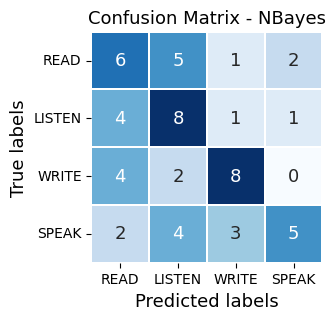

In [ ]:
_, _, acc, cm = train(GaussianNB(priors=[.25, .25, .25, .25]), df, features)
accuracys.append(('NBayes', acc))
display_cm(cm, labels, 'NBayes')

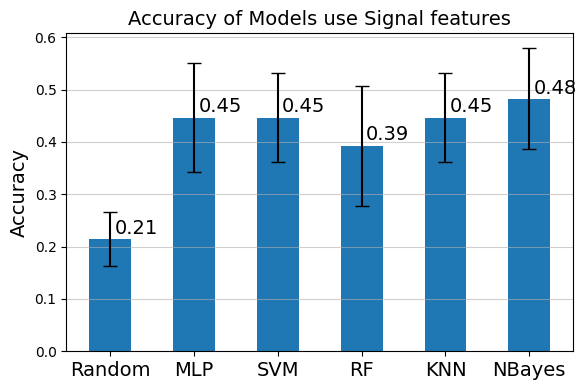

In [ ]:
_, ax = plt.subplots(1, figsize=(6,4))

y = [i[1] for i in accuracys]
err = [ci(x) for x in y]

y = np.nanmean(y, axis=1)
ax.bar(np.arange(len(y)), y, yerr=err, width=0.5, capsize=5)

ax.set_ylabel('Accuracy', fontsize=14)
ax.grid(axis='y', alpha=0.6)
for i in range(len(y)):
  ax.text(i+0.05, y[i]+0.01, np.around(y[i], decimals=2), fontsize=14)

plt.xticks(np.arange(len(y)), labels=[i[0] for i in accuracys], fontsize=14)
plt.title('Accuracy of Models use Signal features',fontsize=14)
plt.tight_layout()

## EXP2： compare variables

In [ ]:
accuracys = []
var_names = [None, 'Complexity', 'Sequence', 'Duration', 'Engagement', 'Fatigue'] #varaible names
vars = [None, 'section','TURN', 'duration', 'engage_score', 'time_spent'] # variable feature labales in the dataset

for var in vars[1:]:
  print('='*5, var, '='*10)
  print(df.groupby('TASK')[var].describe().round(2))

===== section ==========
        count  mean   std  min  25%  50%  75%  max
TASK                                              
LISTEN   14.0   1.5  0.52  1.0  1.0  1.5  2.0  2.0
READ     14.0   1.5  0.52  1.0  1.0  1.5  2.0  2.0
SPEAK    14.0   1.5  0.52  1.0  1.0  1.5  2.0  2.0
WRITE    14.0   1.5  0.52  1.0  1.0  1.5  2.0  2.0
===== TURN ==========
        count  mean   std  min   25%  50%    75%   max
TASK                                                  
LISTEN   14.0  5.86  2.48  2.0  4.25  6.0   8.00   9.0
READ     14.0  6.29  3.36  2.0  3.25  6.0  10.00  10.0
SPEAK    14.0  6.00  2.77  2.0  4.00  6.0   8.75  10.0
WRITE    14.0  5.86  2.66  3.0  3.25  5.5   8.00  10.0
===== duration ==========
        count    mean     std    min     25%     50%     75%     max
TASK                                                                
LISTEN   14.0  219.59   19.94  192.6  204.88  218.25  232.38   254.8
READ     14.0  132.81   51.97   14.6  117.88  122.60  162.88   226.4
SPEAK    14.0  

None
F1:  0.381, ACC:  0.446, AUC: nan
section
F1:  0.425, ACC:  0.482, AUC: nan
TURN
F1:  0.368, ACC:  0.446, AUC: nan
duration
F1:  0.532, ACC:  0.589, AUC: nan
engage_score
F1:  0.501, ACC:  0.536, AUC: nan
time_spent
F1:  0.156, ACC:  0.232, AUC: nan


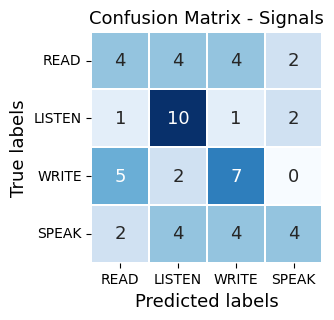

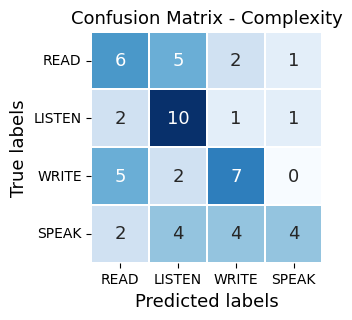

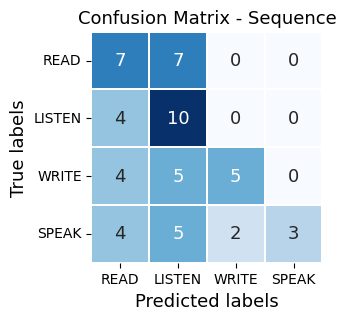

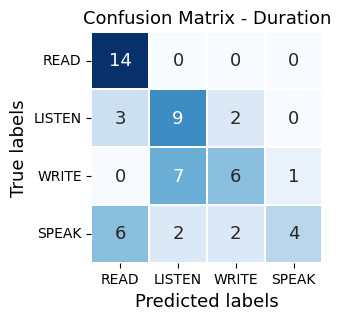

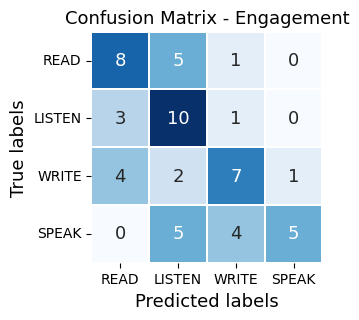

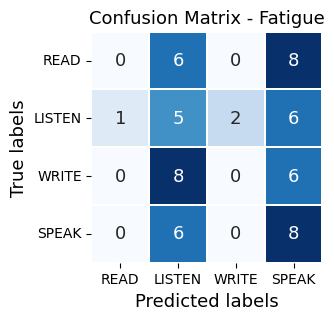

In [ ]:
for i, var in enumerate(vars):
  print(var)
  if var is None:
      _, _, acc, cm = train(SVC(kernel='rbf'), df, features)
      accuracys.append(('Signals', acc))
      display_cm(cm, labels, 'Signals')
  else:
    _, _, acc, cm = train(SVC(kernel='rbf'), df, features, varf=var)
    accuracys.append((var, acc))
    display_cm(cm, labels, var_names[i])

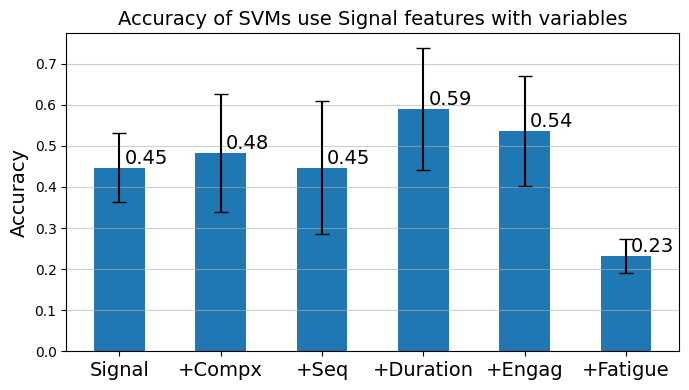

In [ ]:
_, ax = plt.subplots(1, figsize=(7,4))

y = [i[1] for i in accuracys]
err = [ci(x) for x in y]

y = np.nanmean(y, axis=1)
ax.bar(np.arange(len(y)), y, yerr=err, width=0.5, capsize=5)

ax.set_ylabel('Accuracy', fontsize=14)
ax.grid(axis='y', alpha=0.6)
for i in range(len(y)):
  ax.text(i+0.05, y[i]+0.01, np.around(y[i], decimals=2), fontsize=14)

plt.xticks(np.arange(len(y)), labels=['Signal', '+Compx', '+Seq', '+Duration', '+Engag','+Fatigue'], fontsize=14)
plt.title('Accuracy of SVMs use Signal features with variables', fontsize=14)
plt.tight_layout()

### binary classificatin for complexity (section)

F1:  0.369, ACC:  0.446, AUC: 0.402


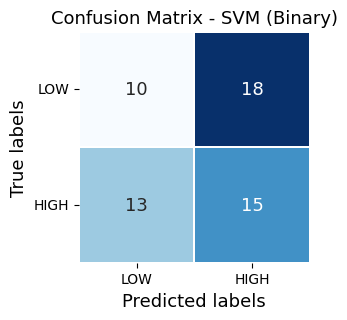

In [ ]:
auc, f1, acc, cm = train(SVC(kernel='linear'), df, features, ylabel='section')
display_cm(cm, ['LOW', 'HIGH'], 'SVM (Binary)') 